In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
# library(monocle)
library(gam)
# library(clusterExperiment)
library(ggplot2)
library(plyr)
# library(MAST)

In [6]:
csv = '/bigstore/GeneralStorage/Zach/MERCI/Autism/MeA_AllCells_DGE.csv'
# autism_data_pd = pd.read_csv(csv,index_col=0)
autism = sc.read(csv,cache=False)
autism = autism.transpose()
autism.obs = pd.DataFrame(index=autism.obs.index.rename('barcode'))
autism.obs['sample'] = info_df_Neuron['sample']
autism.obs['groups'] = info_df_Neuron['cell_types']
# adata_tmp.obs['region'] = [sample.split("_")[0]]*adata_tmp.n_obs
# adata_tmp.obs['donor'] = [sample.split("_")[1]]*adata_tmp.n_obs
autism.obs

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


NameError: name 'info_df_Neuron' is not defined

In [17]:
# Annotate the data sets
print(autism.obs['sample'].value_counts())

E49    1312
E47    1052
E43    1029
E51     803
E50     788
E42     759
E40     681
E45     667
E44     664
E52     657
E46     646
E48     616
E41     449
Name: sample, dtype: int64


In [18]:
# Quality control - calculate QC covariates
autism.obs['n_counts'] = autism.X.sum(1)
autism.obs['log_counts'] = np.log(autism.obs['n_counts'])
autism.obs['n_genes'] = (autism.X > 0).sum(1)
autism.obs
# mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
# adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

sample  groups  n_counts  log_counts  n_genes
barcode                                                       
E40_GGATAGTCCAGA    E40      14   27976.0   10.239102     2326
E40_TAACGACATTCG    E40      10   22455.0   10.019269     2220
E40_CGTTCGTTCGAC    E40      10   18581.0    9.829895     2097
E40_CTGCAGTATTTT    E40      10   13245.0    9.491375     1907
E40_CCTATGGGGATA    E40       2   11571.0    9.356257     1895
...                 ...     ...       ...         ...      ...
E51_AGATCTCACCTG    E51       2     114.0    4.736198       83
E51_GCGGTCGCGTTA    E51       1     149.0    5.003946      100
E51_GTCTTTGCGAGT    E51       1     153.0    5.030438      116
E51_CATGAAGATGCC    E51       1      88.0    4.477337       73
E51_CGATCGAGATAA    E51       2     152.0    5.023880      110

[10123 rows x 5 columns]

... storing 'sample' as categorical


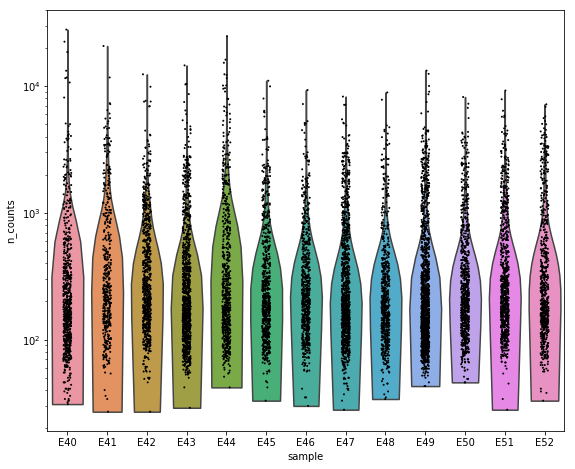

In [19]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(autism, 'n_counts', groupby='sample', size=2, log=True, cut=0)
# t2 = sc.pl.violin(autism, 'mt_frac', groupby='sample')

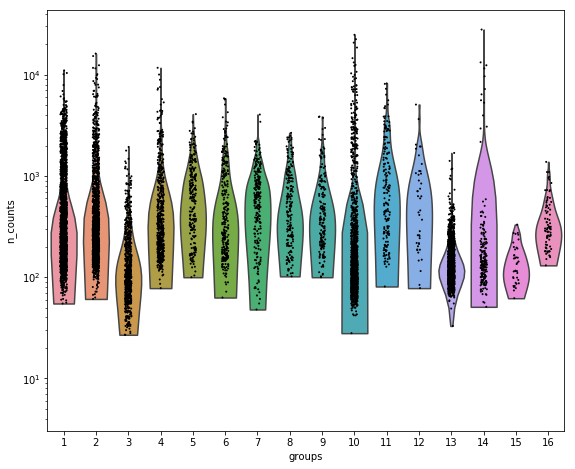

In [20]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(autism, 'n_counts', groupby='groups', size=2, log=True, cut=0)
# t2 = sc.pl.violin(autism, 'mt_frac', groupby='sample')

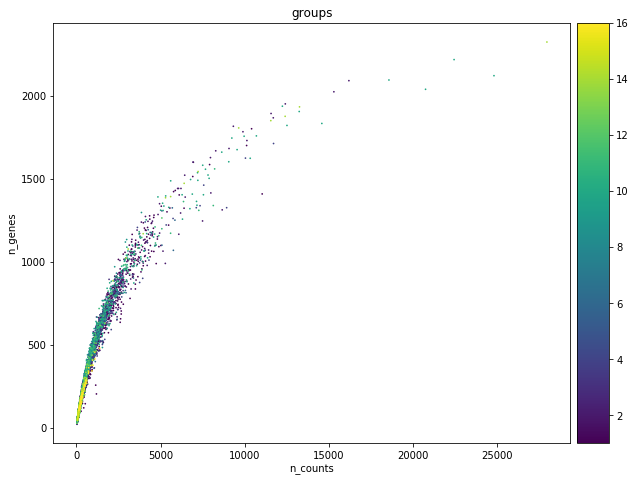

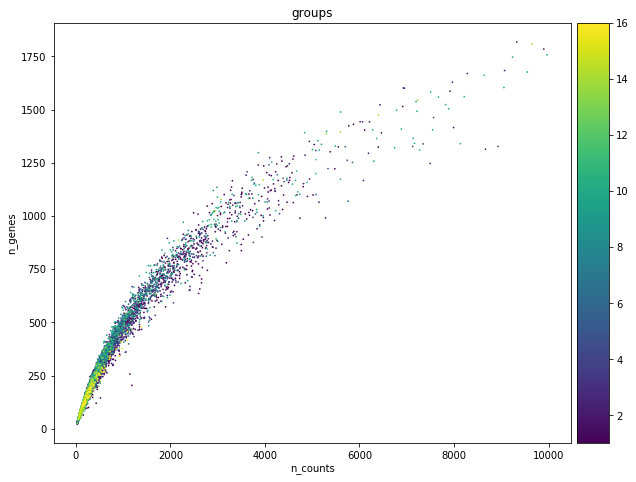

In [21]:
#Data quality summary plots
p1 = sc.pl.scatter(autism, 'n_counts', 'n_genes', color='groups')
p2 = sc.pl.scatter(autism[autism.obs['n_counts']<10000], 'n_counts', 'n_genes', color='groups')

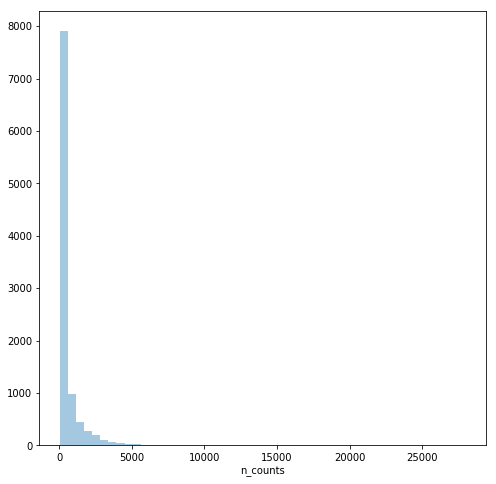

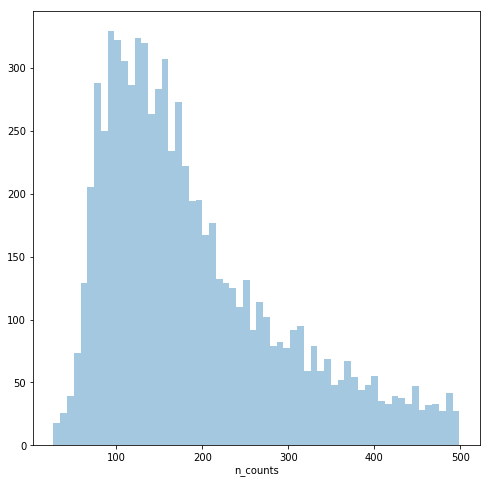

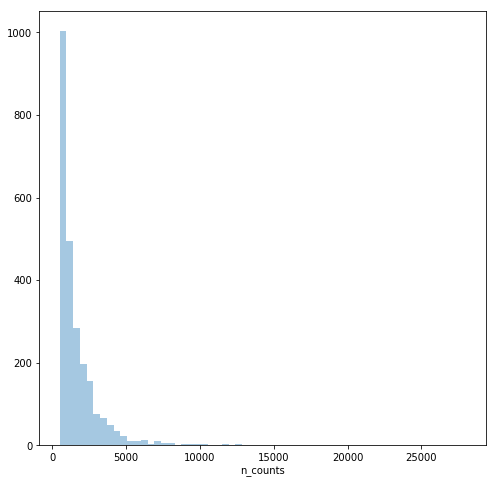

In [22]:
#Thresholding decision: counts
p3 = sb.distplot(autism.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(autism.obs['n_counts'][autism.obs['n_counts']<500], kde=False, bins=60)
plt.show()

p5 = sb.distplot(autism.obs['n_counts'][autism.obs['n_counts']>500], kde=False, bins=60)
plt.show()

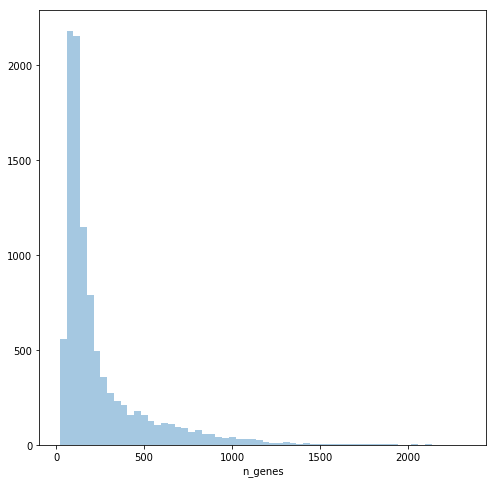

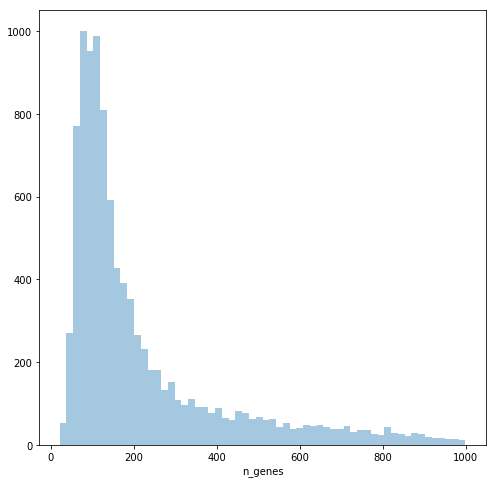

In [23]:
#Thresholding decision: genes
p6 = sb.distplot(autism.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(autism.obs['n_genes'][autism.obs['n_genes']<1000], kde=False, bins=60)
plt.show()


In [47]:
#Perform a clustering for scran normalization in clusters
autism_pp = autism.copy()
sc.pp.normalize_per_cell(autism_pp, counts_per_cell_after=1e6)
sc.pp.log1p(autism_pp)
sc.pp.pca(autism_pp, n_comps=15)
sc.pp.neighbors(autism_pp)
sc.tl.louvain(autism_pp, key_added='group', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
computing PCA on highly variable genes


/home/zach/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:291: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
autism_pp.obs

In [27]:
#Preprocess variables for scran normalization
input_groups = autism_pp.obs['groups']
data_mat = autism_pp.X.T

In [28]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [30]:
#Delete adata_pp
del autism_pp

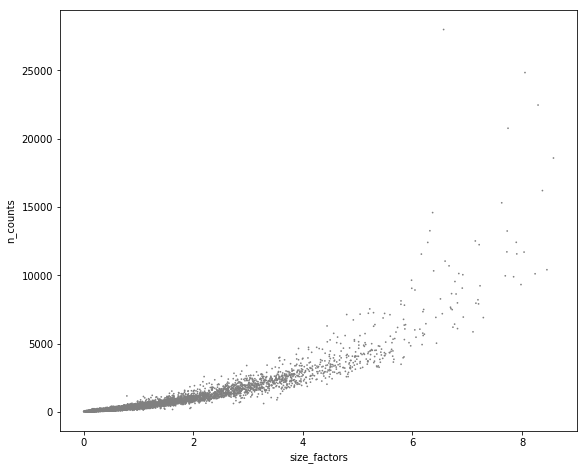

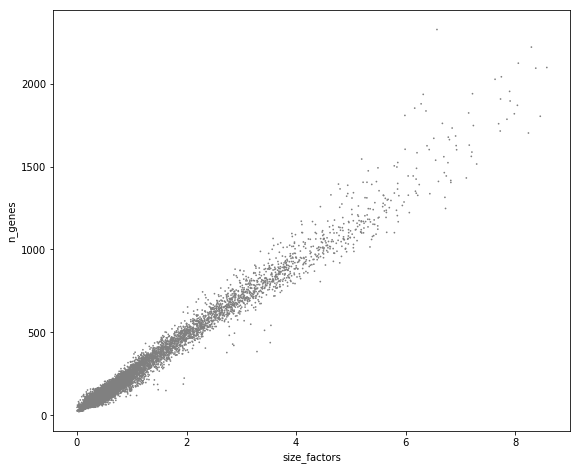

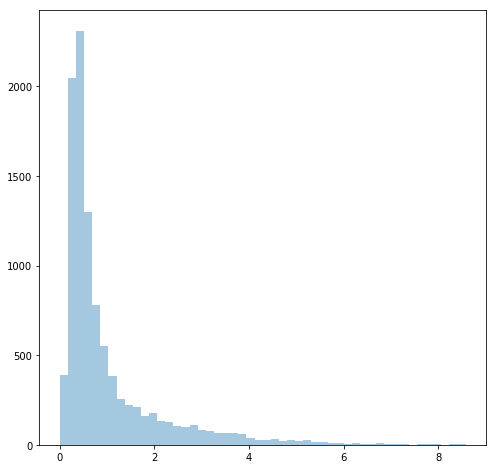

In [29]:
# Visualize the estimated size factors
autism.obs['size_factors'] = size_factors

sc.pl.scatter(autism, 'size_factors', 'n_counts')
sc.pl.scatter(autism, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [31]:
#Keep the count data in a counts layer
autism.layers["counts"] = autism.X.copy()

In [32]:
#Normalize adata 
autism.X /= autism.obs['size_factors'].values[:,None]
sc.pp.log1p(autism)

In [33]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
autism.raw = autism

In [34]:
# ComBat batch correction
sc.pp.combat(autism, key='sample')

Standardizing Data across genes.

Found 13 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/home/zach/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:269: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_it_sol" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for 'sum2', defined at /home/zach/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (311)

File "../../../miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 311:
def _it_sol(s_data, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001) -> Tuple[float, float]:
    <source elided>
        g_new = (t2*n*g_hat + d_old*g_bar) / (t2*n + d_old)
        sum2 = s_data - g_new.reshape((g_new.shape[0], 1)) @ np.ones((1, s_data.shape[1]))
        ^

[1] During: typing of assignment at /home/zach/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (313)

File "../../../miniconda3/envs/sc-tutor

Adjusting data



In [40]:
sc.pp.highly_variable_genes(autism, flavor='cell_ranger', n_top_genes=3000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(autism.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 3000


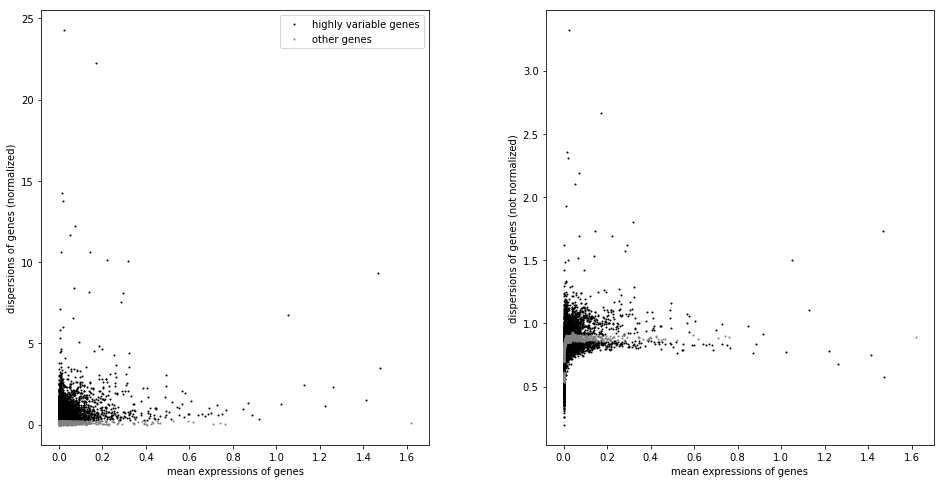

In [41]:
sc.pl.highly_variable_genes(autism)

In [42]:
# Calculate the visualizations
sc.pp.pca(autism, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(autism)

sc.tl.tsne(autism, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(autism)
sc.tl.diffmap(autism)
sc.tl.draw_graph(autism)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/zach/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/zach/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:46)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.98947424 0.98335105 0.98204756 0.9784519  0.9651653
     0.95914483 0.9546301  0.94620615 0.9377946  0.9331584  0.92606413
     0.91568786 0.9148346  0.9094521 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata

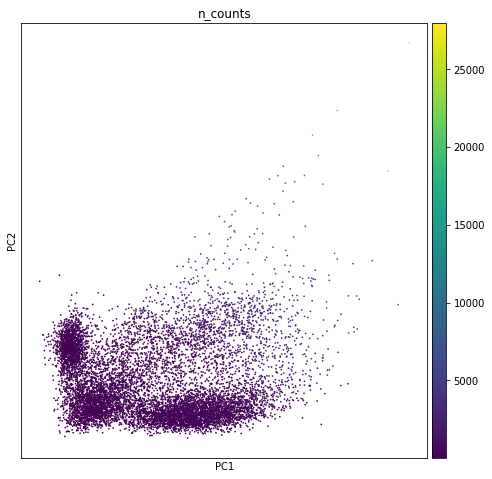

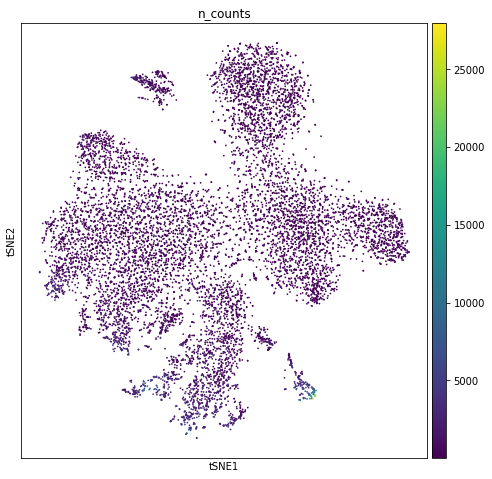

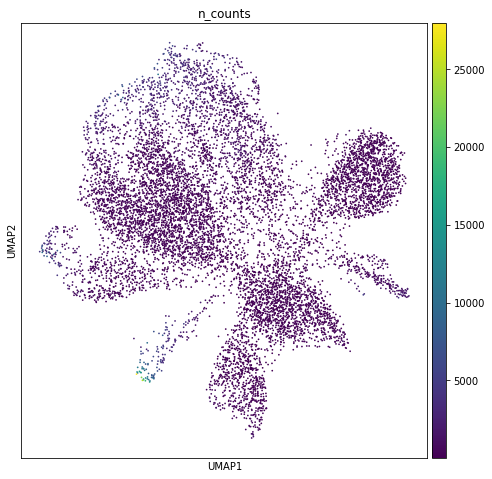

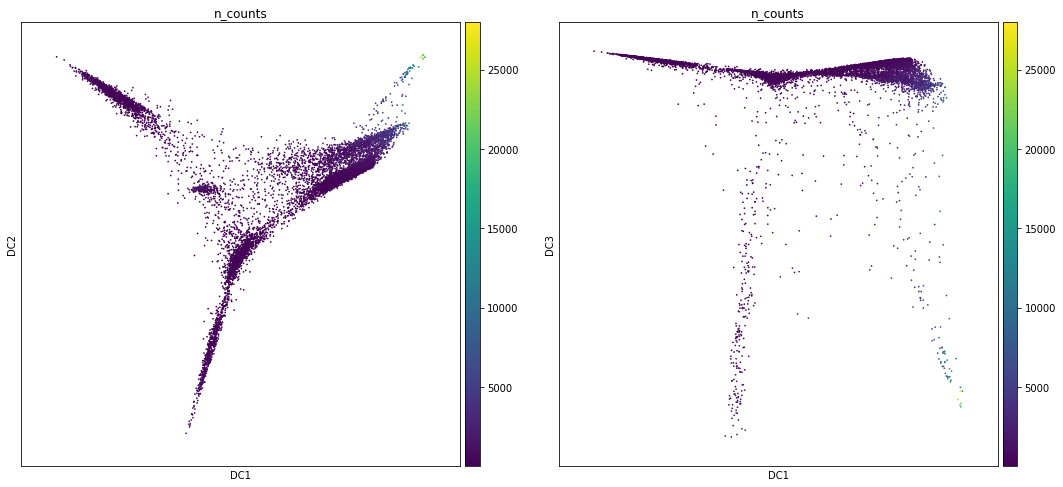

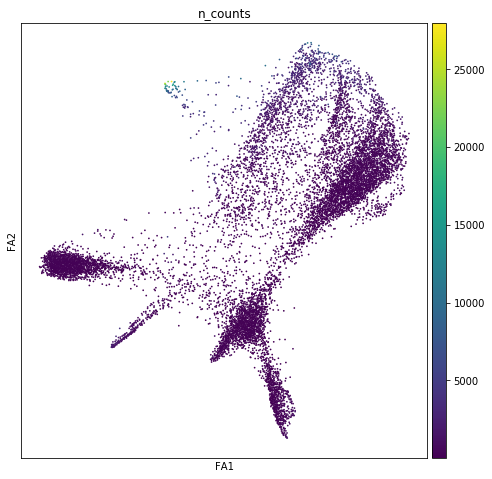

In [43]:
sc.pl.pca_scatter(autism, color='n_counts')
sc.pl.tsne(autism, color='n_counts')
sc.pl.umap(autism, color='n_counts')
sc.pl.diffmap(autism, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(autism, color='n_counts')

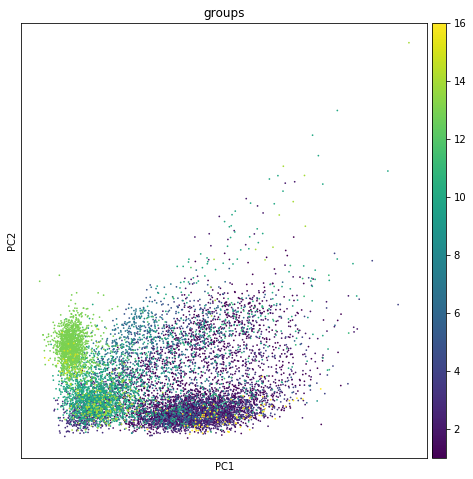

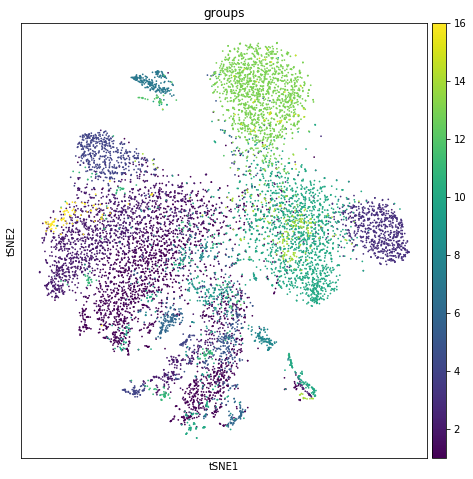

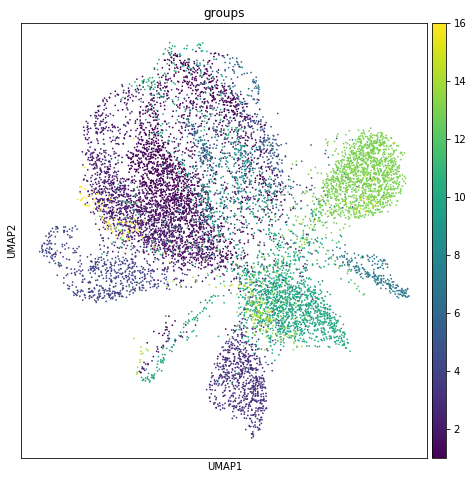

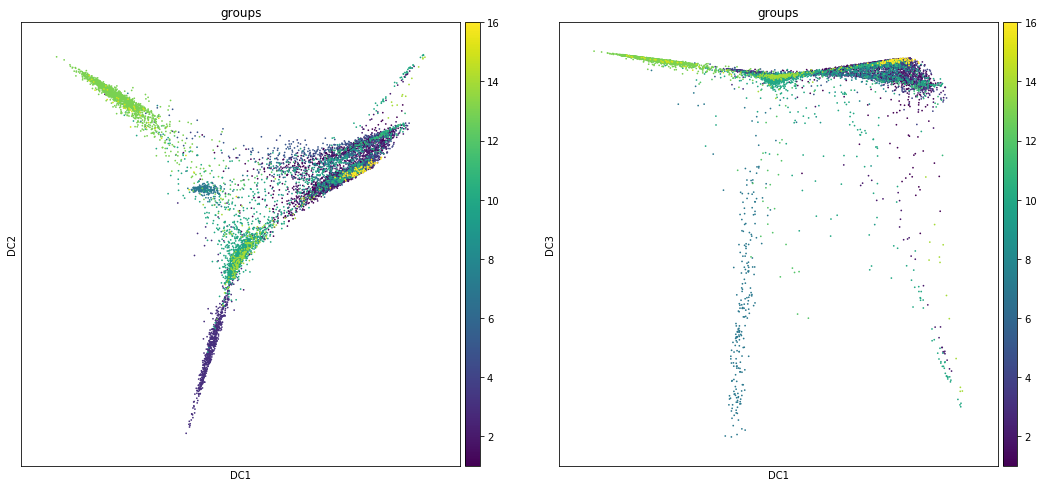

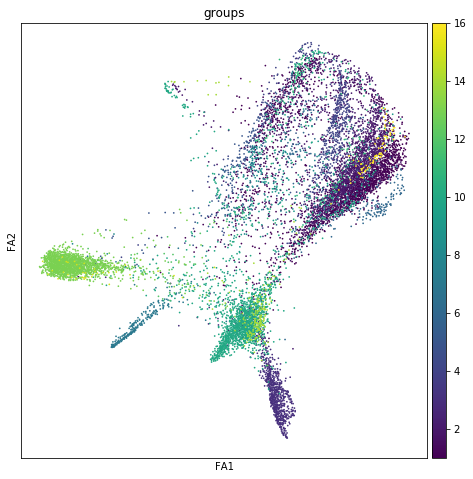

In [44]:
sc.pl.pca_scatter(autism, color='groups')
sc.pl.tsne(autism, color='groups')
sc.pl.umap(autism, color='groups')
sc.pl.diffmap(autism, color='groups', components=['1,2','1,3'])
sc.pl.draw_graph(autism, color='groups')

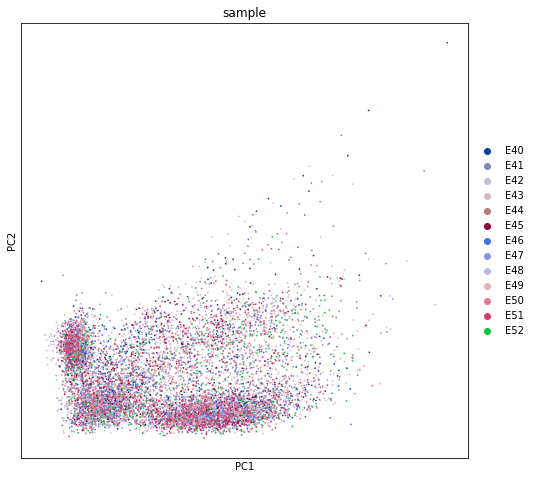

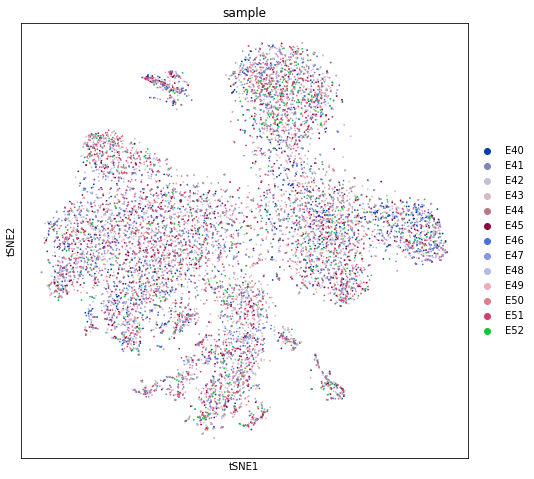

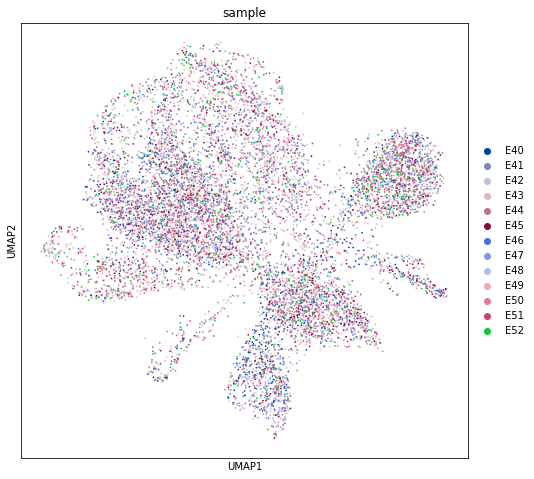

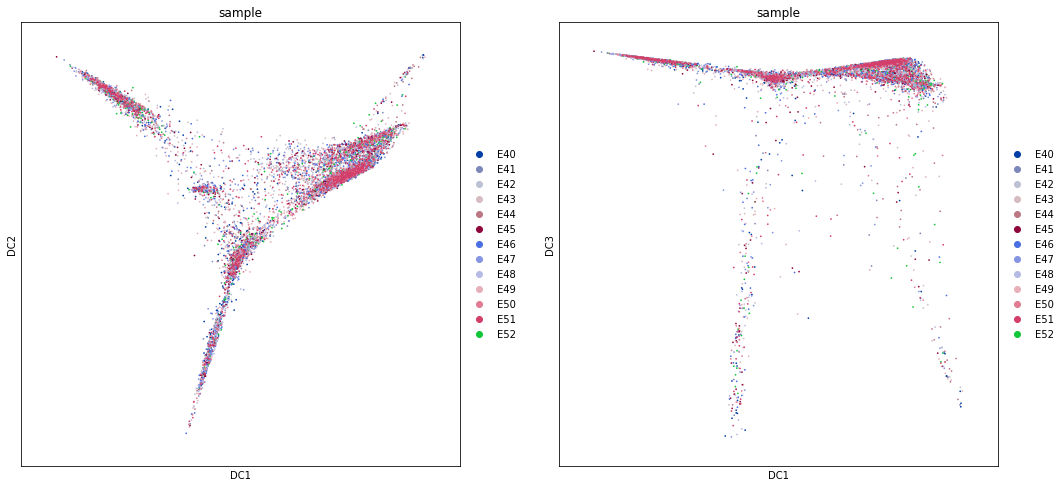

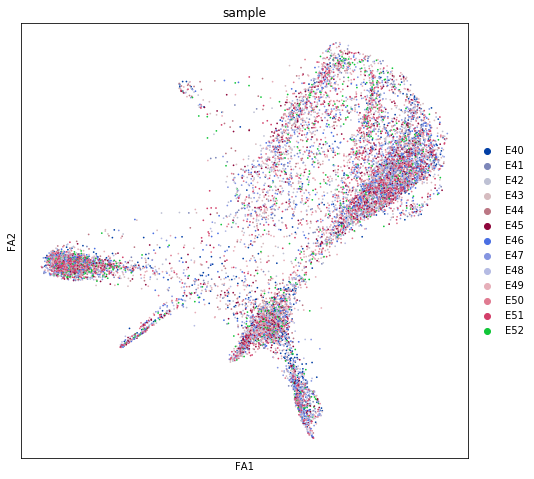

In [48]:
sc.pl.pca_scatter(autism, color='sample')
sc.pl.tsne(autism, color='sample')
sc.pl.umap(autism, color='sample')
sc.pl.diffmap(autism, color='sample', components=['1,2','1,3'])
sc.pl.draw_graph(autism, color='sample')

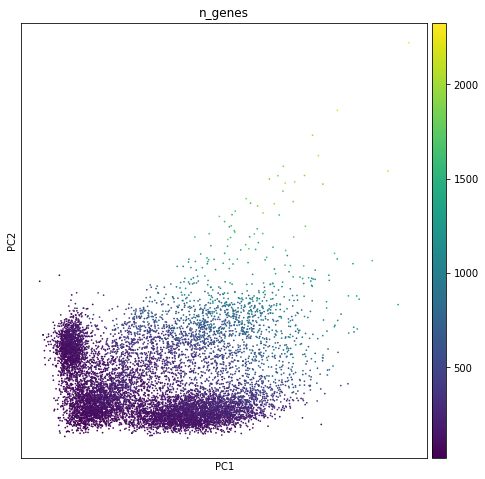

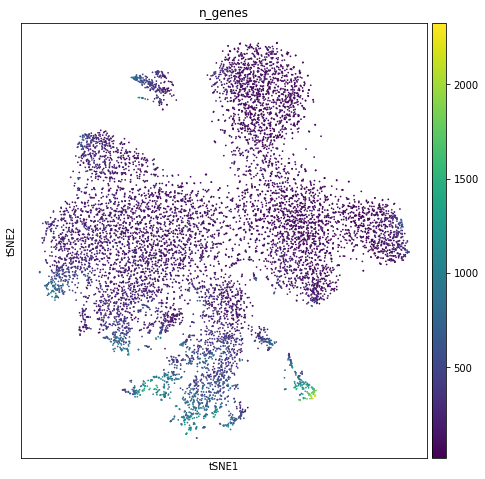

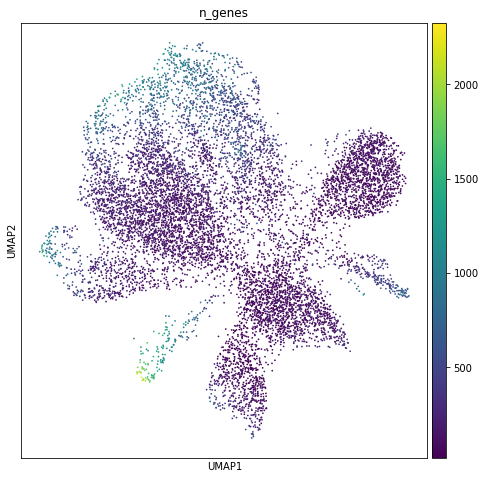

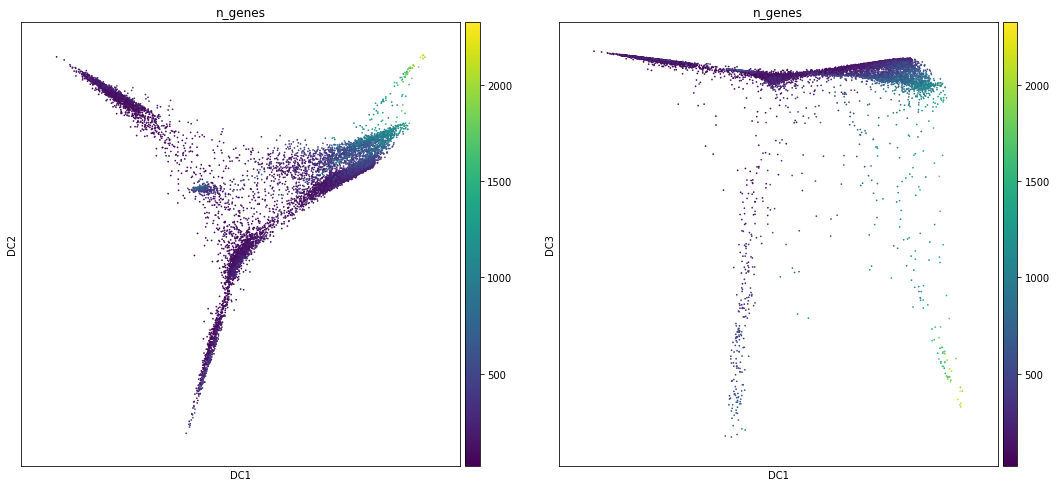

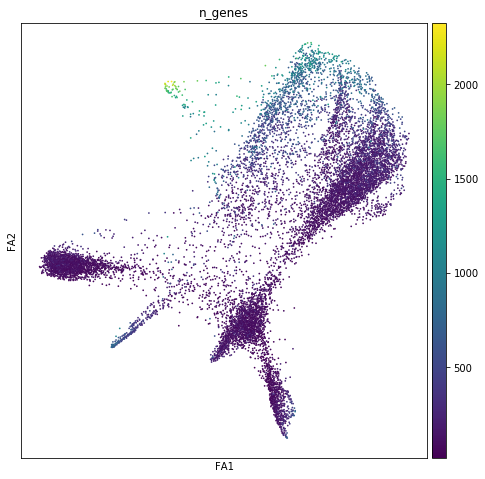

In [49]:
sc.pl.pca_scatter(autism, color='n_genes')
sc.pl.tsne(autism, color='n_genes')
sc.pl.umap(autism, color='n_genes')
sc.pl.diffmap(autism, color='n_genes', components=['1,2','1,3'])
sc.pl.draw_graph(autism, color='n_genes')

In [50]:
cc_genes_file = '/home/zach/PythonRepos/single-cell-tutorial/Macosko_cell_cycle_genes.txt'
#Score cell cycle and visualize the effect:
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = autism.var_names[np.in1d(autism.var_names, s_genes_mm)]
g2m_genes_mm_ens = autism.var_names[np.in1d(autism.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(autism, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


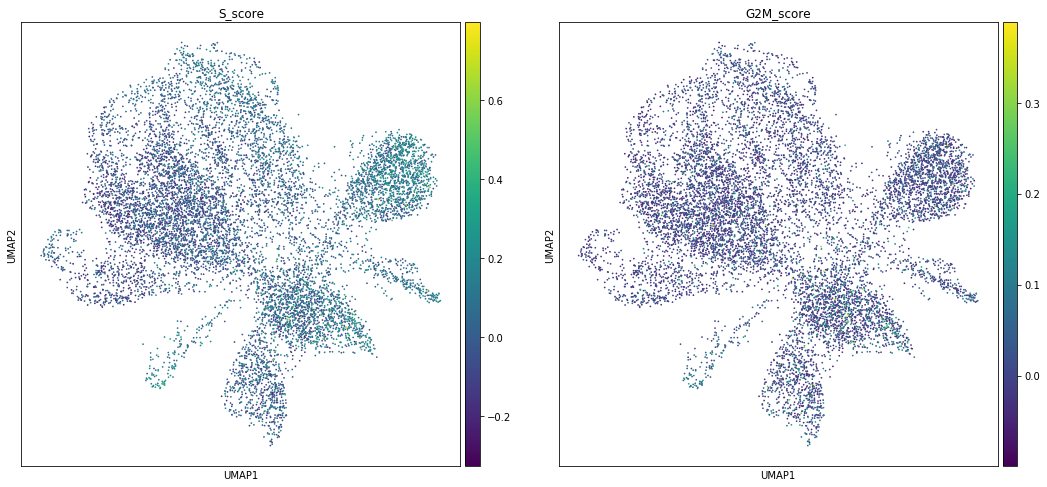

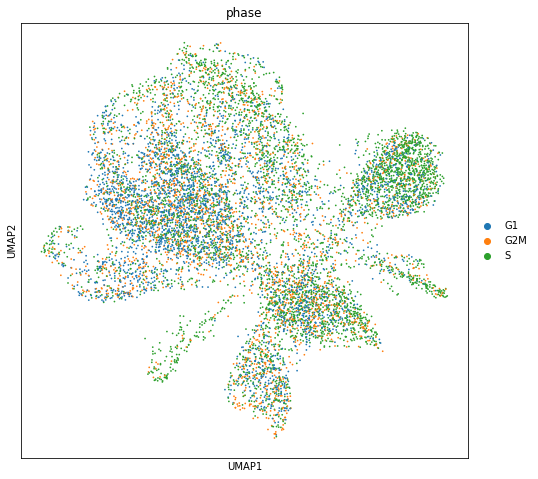

In [51]:
sc.pl.umap(autism, color=['S_score', 'G2M_score'], use_raw=False)
sc.pl.umap(autism, color='phase', use_raw=False)

In [52]:
# Perform clustering - using highly variable genes
sc.tl.louvain(autism, key_added='louvain_r1')
sc.tl.louvain(autism, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:02)


In [53]:
autism.obs['louvain_r0.5'].value_counts()

0    3144
1    1782
2    1775
3    1535
4     656
5     560
6     361
7     168
8     142
Name: louvain_r0.5, dtype: int64

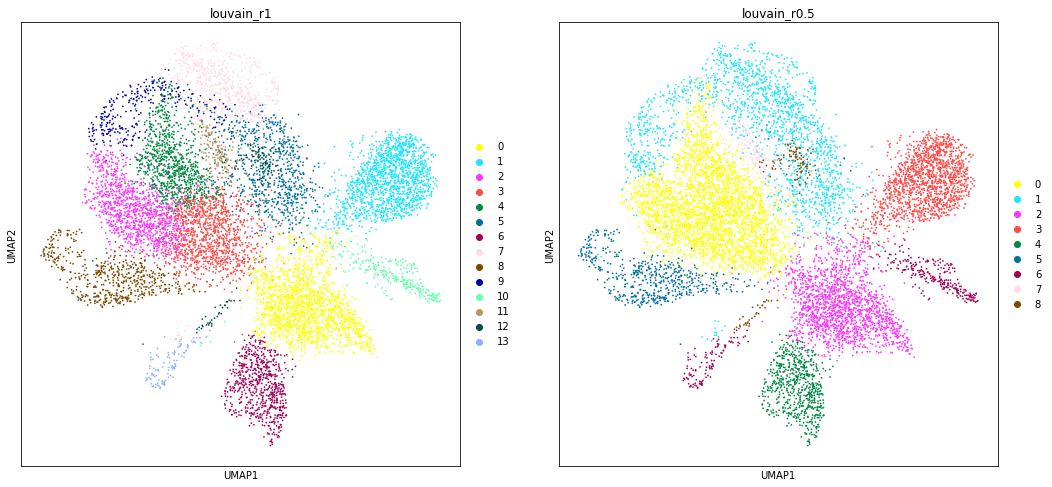

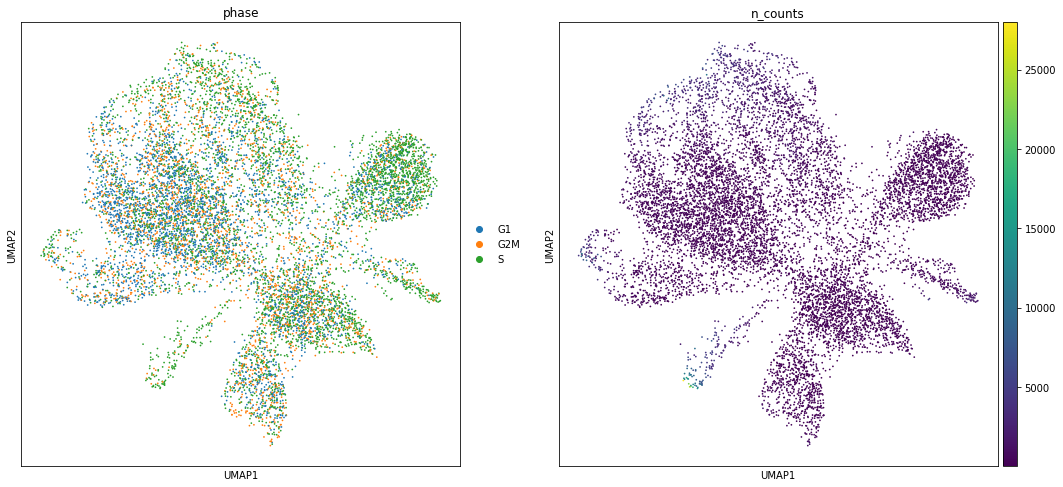

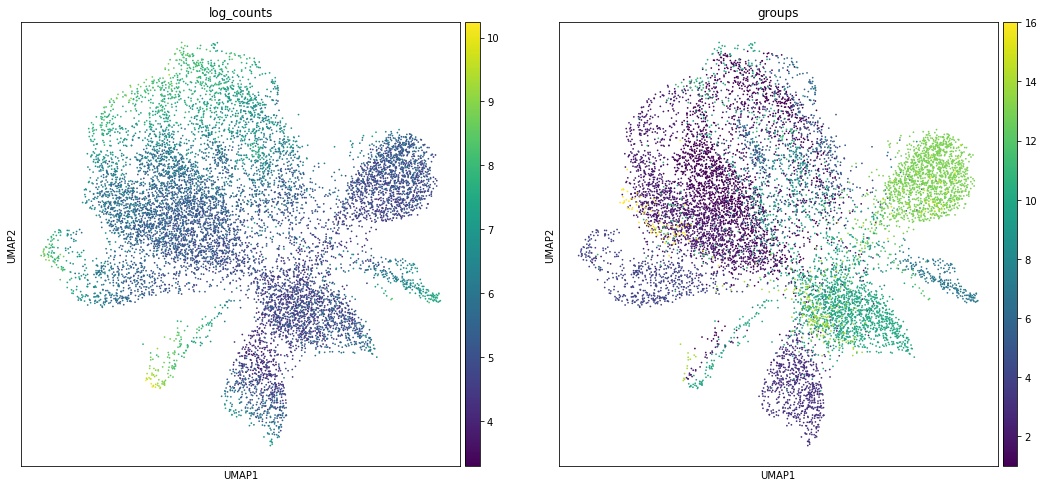

In [57]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(autism, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(autism, color=['phase', 'n_counts'])
sc.pl.umap(autism, color=['log_counts', 'groups'])

In [58]:
#Calculate marker genes
sc.tl.rank_genes_groups(autism, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished: added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


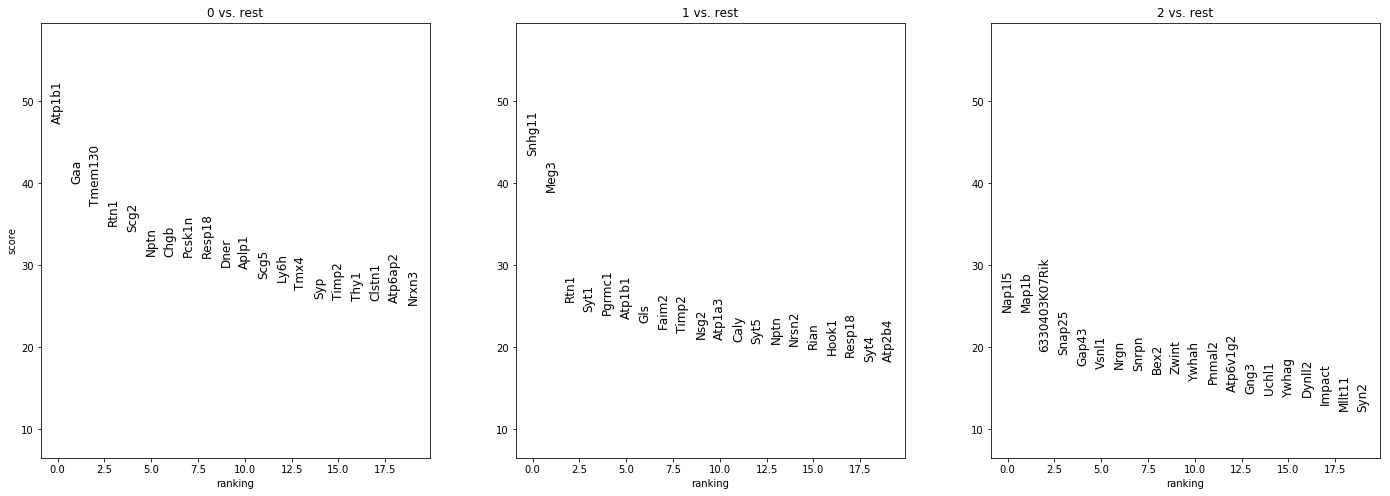

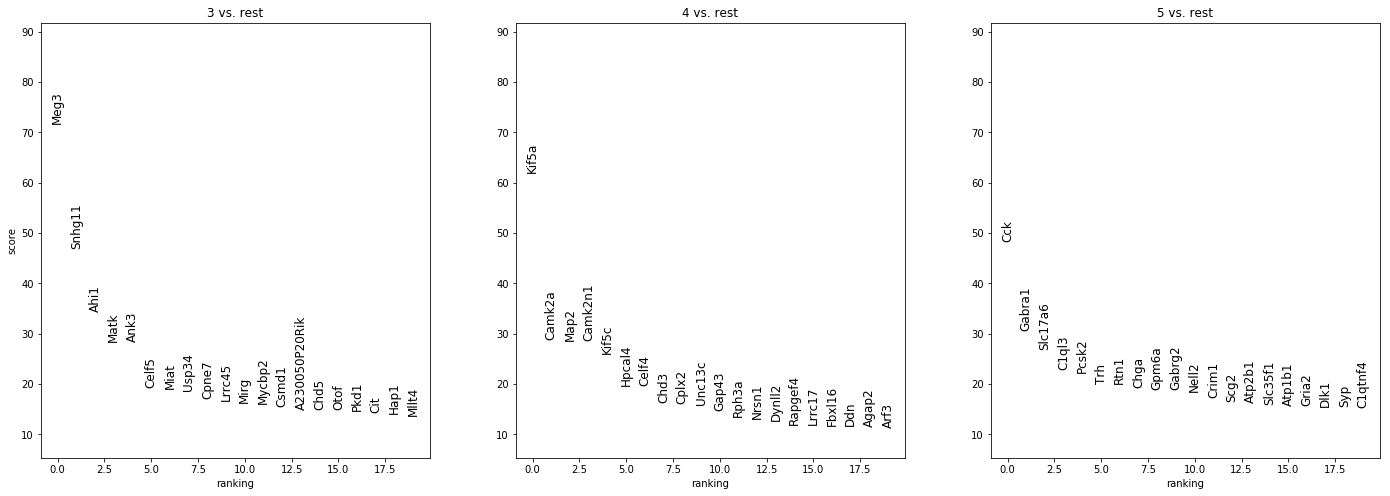

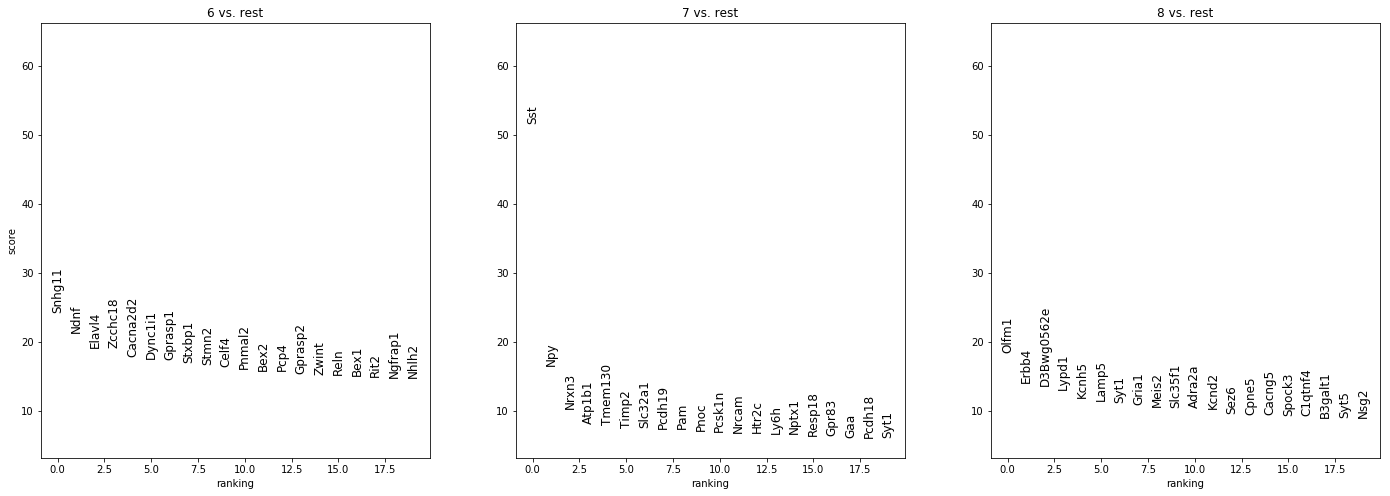

In [60]:
#Plot marker genes
sc.pl.rank_genes_groups(autism, key='rank_genes_r0.5', groups=['0','1','2'], fontsize=12)
sc.pl.rank_genes_groups(autism, key='rank_genes_r0.5', groups=['3','4','5'], fontsize=12)
sc.pl.rank_genes_groups(autism, key='rank_genes_r0.5', groups=['6', '7', '8'], fontsize=12)


In [65]:
autism.raw.X

array([[0.        , 0.        , 0.        , ..., 0.        , 1.3974004 ,
        0.1417023 ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.115231  ,
        0.5444301 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.96814764,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)